# Process Fruit 360 with PCA, Random Forest and SVM

## Imports

In [1]:
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans
import seaborn as sns


In [2]:
import joblib
save_path = "./PCA_SVM_RF/"
scaler_path = save_path+"scaler.joblib"
pca_path = save_path+"pca.joblib"
rf_clf_path = save_path+"rf_clf.joblib"
svm_clf_path = save_path+"svm_clf.joblib"

## Read data

In [3]:
fruit_images = []
labels = []
image_class_num = []
image_width = 50
image_height = 50
path = "./fruits-360/Training/"

with os.scandir(path) as dirs:
    for fruit_dir in dirs:
        fruit_label = fruit_dir.name
        num = len(fruit_images)
        with os.scandir(fruit_dir.path) as files:
            for image_file in files:
                image = cv2.imread(image_file.path, cv2.IMREAD_COLOR)

                image = cv2.resize(image, (image_width, image_height))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                fruit_images.append(image)
                labels.append(fruit_label)
        image_class_num.append(len(fruit_images)-num)
        print(f"\rRead {len(fruit_images)-num} images from {fruit_dir.path}",end='')

fruit_images = np.array(fruit_images)
labels = np.array(labels)
print(f"===============================\nRead {len(fruit_images)} new images in total.")

Read 475 images from ./fruits-360/Training/Watermelonlowpeneds===============================
Read 67692 new images in total.


In [4]:
d = {'fruit name': labels, 'image number': image_class_num}
df = pd.DataFrame(data=d)
df.head()

fruit name  image number
0      Apple Braeburn           492
1  Apple Crimson Snow           444
2      Apple Golden 1           480
3      Apple Golden 2           492
4      Apple Golden 3           481

## Fruit Distribution

Text(0.5, 1.0, 'Distribution')

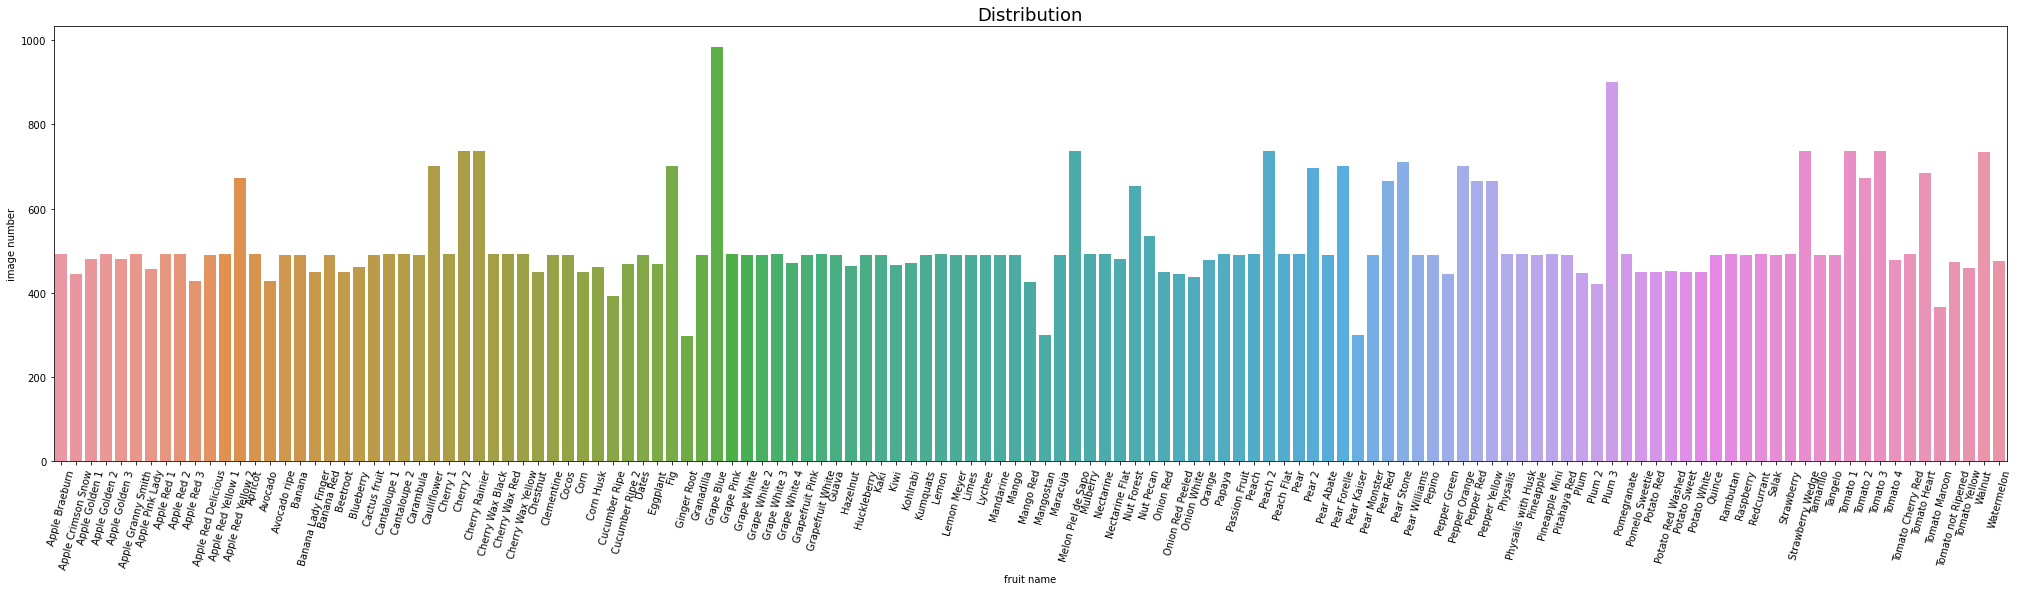

In [5]:
f, ax = plt.subplots(figsize=(35, 8))

# sns.barplot(x='image number',y='fruit name',data=df)
sns.barplot(y='image number',x='fruit name',data=df)
plt.xticks(rotation=75)
plt.title('Distribution', fontsize=18)

In [6]:
label_to_id_dict = {v:i for i,v in enumerate((labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
print(f"There are {len(label_to_id_dict)} classes of fruits.")

There are 131 classes of fruits.


In [7]:
print(id_to_label_dict)

{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3', 5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3', 10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus fruit', 22: 'Cantaloupe 1', 23: 'Cantaloupe 2', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry 1', 27: 'Cherry 2', 28: 'Cherry Rainier', 29: 'Cherry Wax Black', 30: 'Cherry Wax Red', 31: 'Cherry Wax Yellow', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn Husk', 37: 'Cucumber Ripe', 38: 'Cucumber Ripe 2', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger Root', 43: 'Granadilla', 44: 'Grape Blue', 45: 'Grape Pink', 46: 'Grape White', 47: 'Grape White 2', 48: 'Grape White 3', 49: 'Grape White 4', 50: 'Grapefruit Pink', 51: 'Grape

In [8]:
label_ids = np.array([label_to_id_dict[x] for x in labels])
label_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130])

In [9]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            # axs[i, j].xaxis.set_ticklabels([])
            # axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1        

## Show some fruits pictures

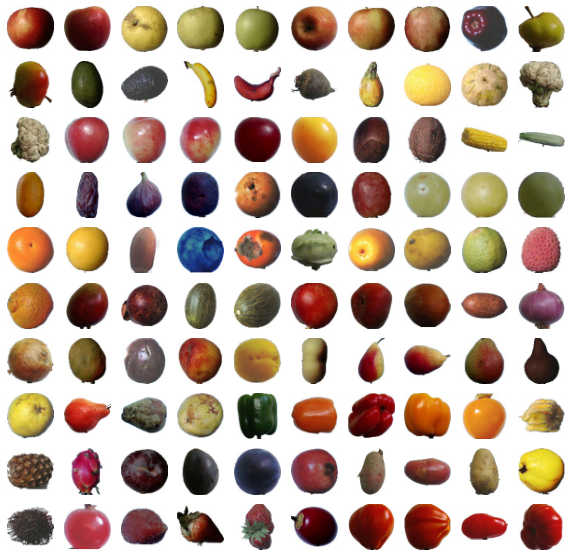

In [10]:
plot_image_grid(fruit_images[:64000:640], 10, 10, figsize=(10,10))

# Visualize the data with PCA and t-SNE

## PCA

In [11]:
scaler = StandardScaler()

In [12]:
images_flattened = [i.flatten() for i in fruit_images]

In [13]:

if os.path.exists(scaler_path):
    print("Loading scaler from " + scaler_path)
    scaler = joblib.load(scaler_path)
else:
    print("Fitting scaler")
    scaler.fit(images_flattened)
scaler

Loading scaler from ./PCA_SVM_RF/scaler.joblib


StandardScaler()

In [14]:
images_scaled = scaler.transform(images_flattened)
images_scaled.shape

(67692, 7500)

In [15]:
pca = PCA(n_components=50)

In [16]:
if os.path.exists(pca_path):
    print("Loading pca from " + pca_path)
    pca = joblib.load(pca_path)
else:
    print("Fitting pca")
    pca.fit(images_scaled)
pca

Loading pca from ./PCA_SVM_RF/pca.joblib


PCA(n_components=50)

In [17]:
pca_result = pca.transform(images_scaled)
pca_result.shape

(67692, 50)

## Visialize data with t-SNE

In [16]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [17]:
def visualize_scatter(data_2d, label_ids, id_to_label_dict=None, figsize=(20,20)):
    if not id_to_label_dict:
        id_to_label_dict = {v:i for i,v in enumerate(np.unique(label_ids))}
    
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    cmap = plt.cm.get_cmap("jet", nb_classes)
    
    for i, label_id in enumerate(np.unique(label_ids)):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    c= cmap(i),
                    linewidth='5',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    #plt.legend(loc='best')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),
          fancybox=True, shadow=True, ncol=1, fontsize=figsize[0])

In [36]:
def visualize_scatter_with_images(data_2d, images, figsize=(image_width,image_height), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    artists = []
    for xy, i in zip(data_2d, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(data_2d)
    ax.autoscale()
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

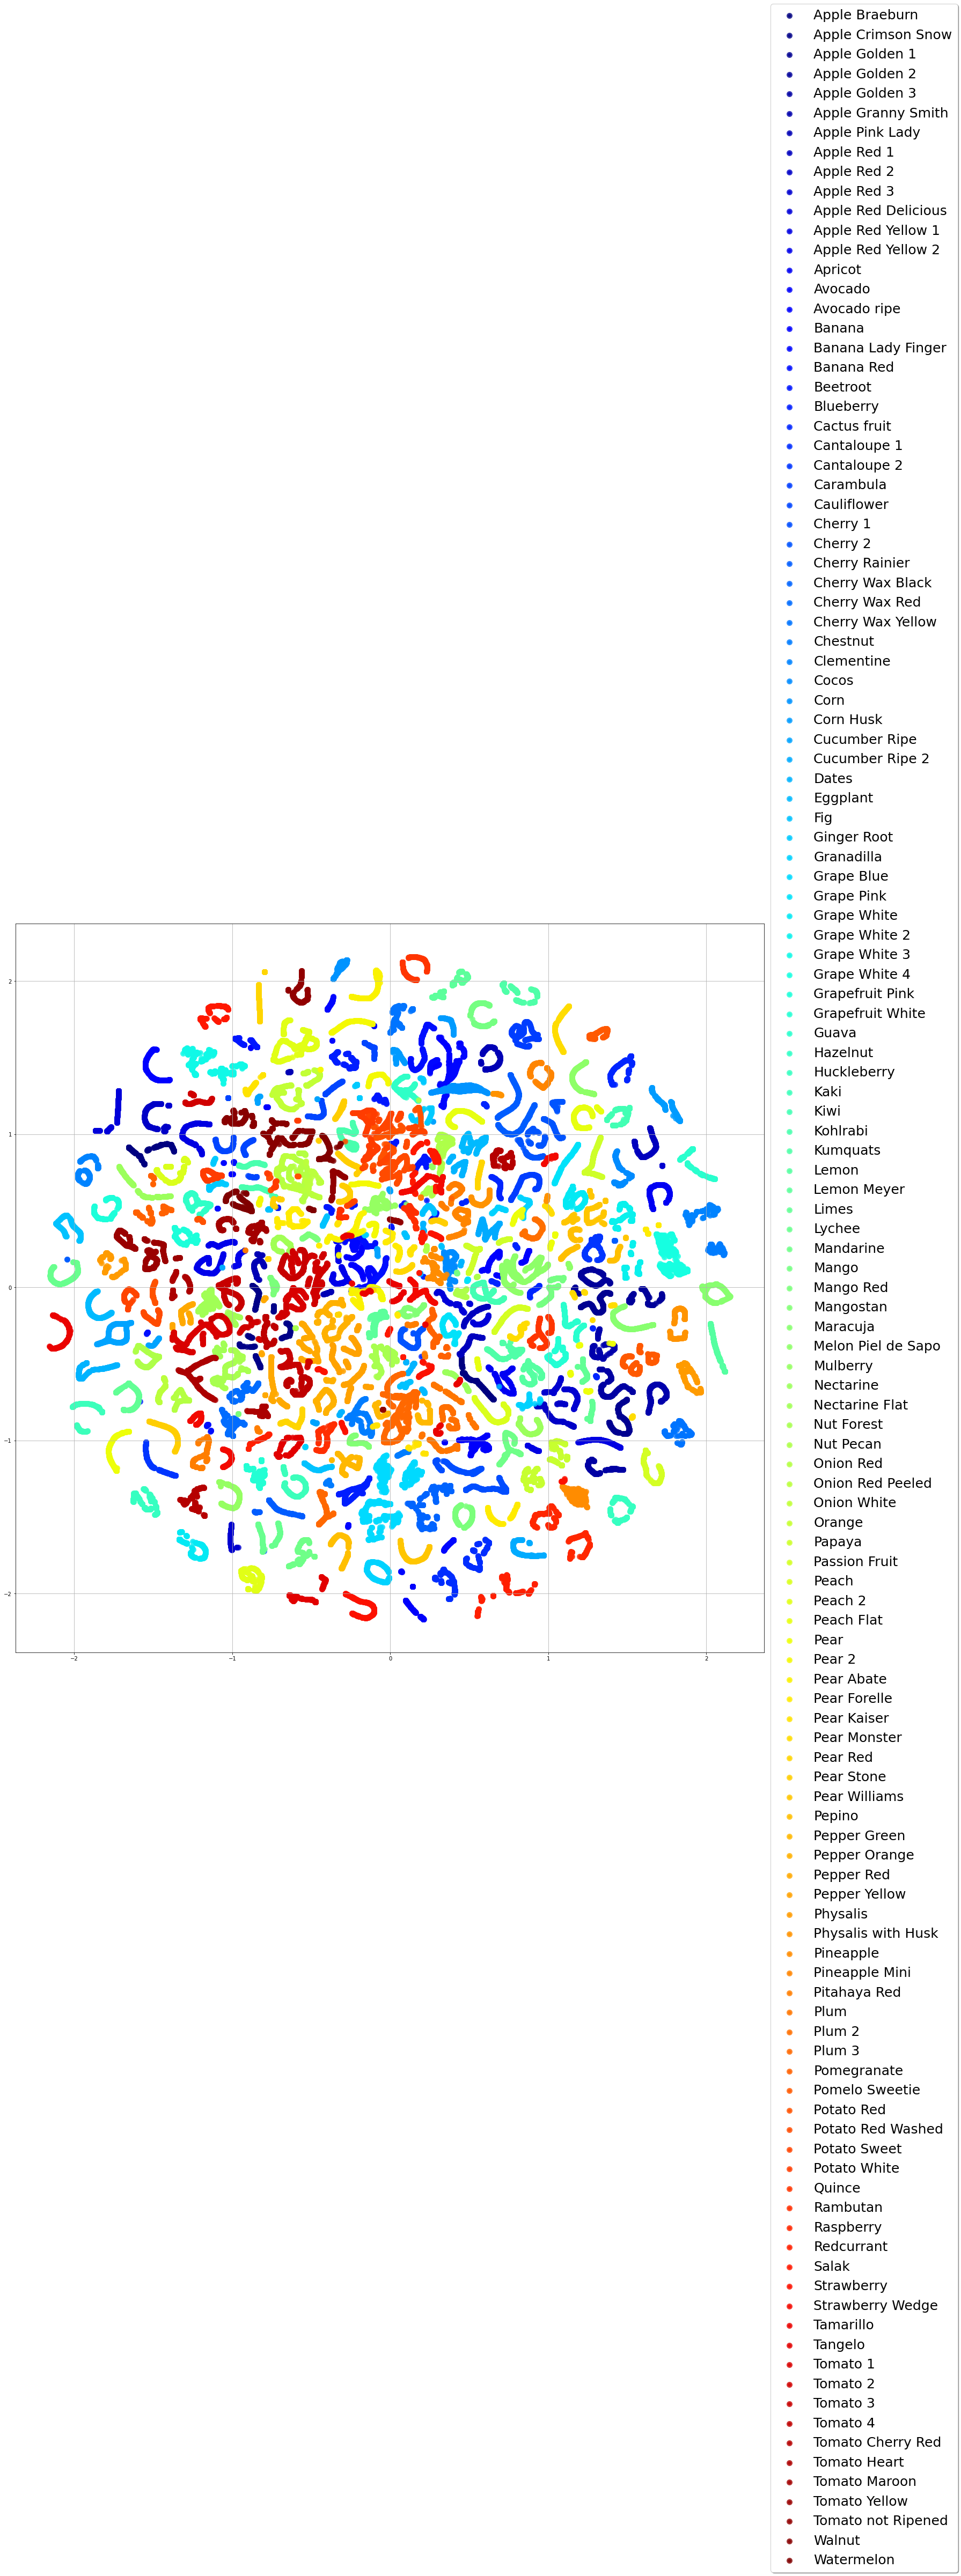

In [37]:
visualize_scatter(tsne_result_scaled, label_ids, id_to_label_dict, figsize=(25, 25))

Just like a 2yo kid draws :P

Btw. we can call it art and sell for a lot of...computational power

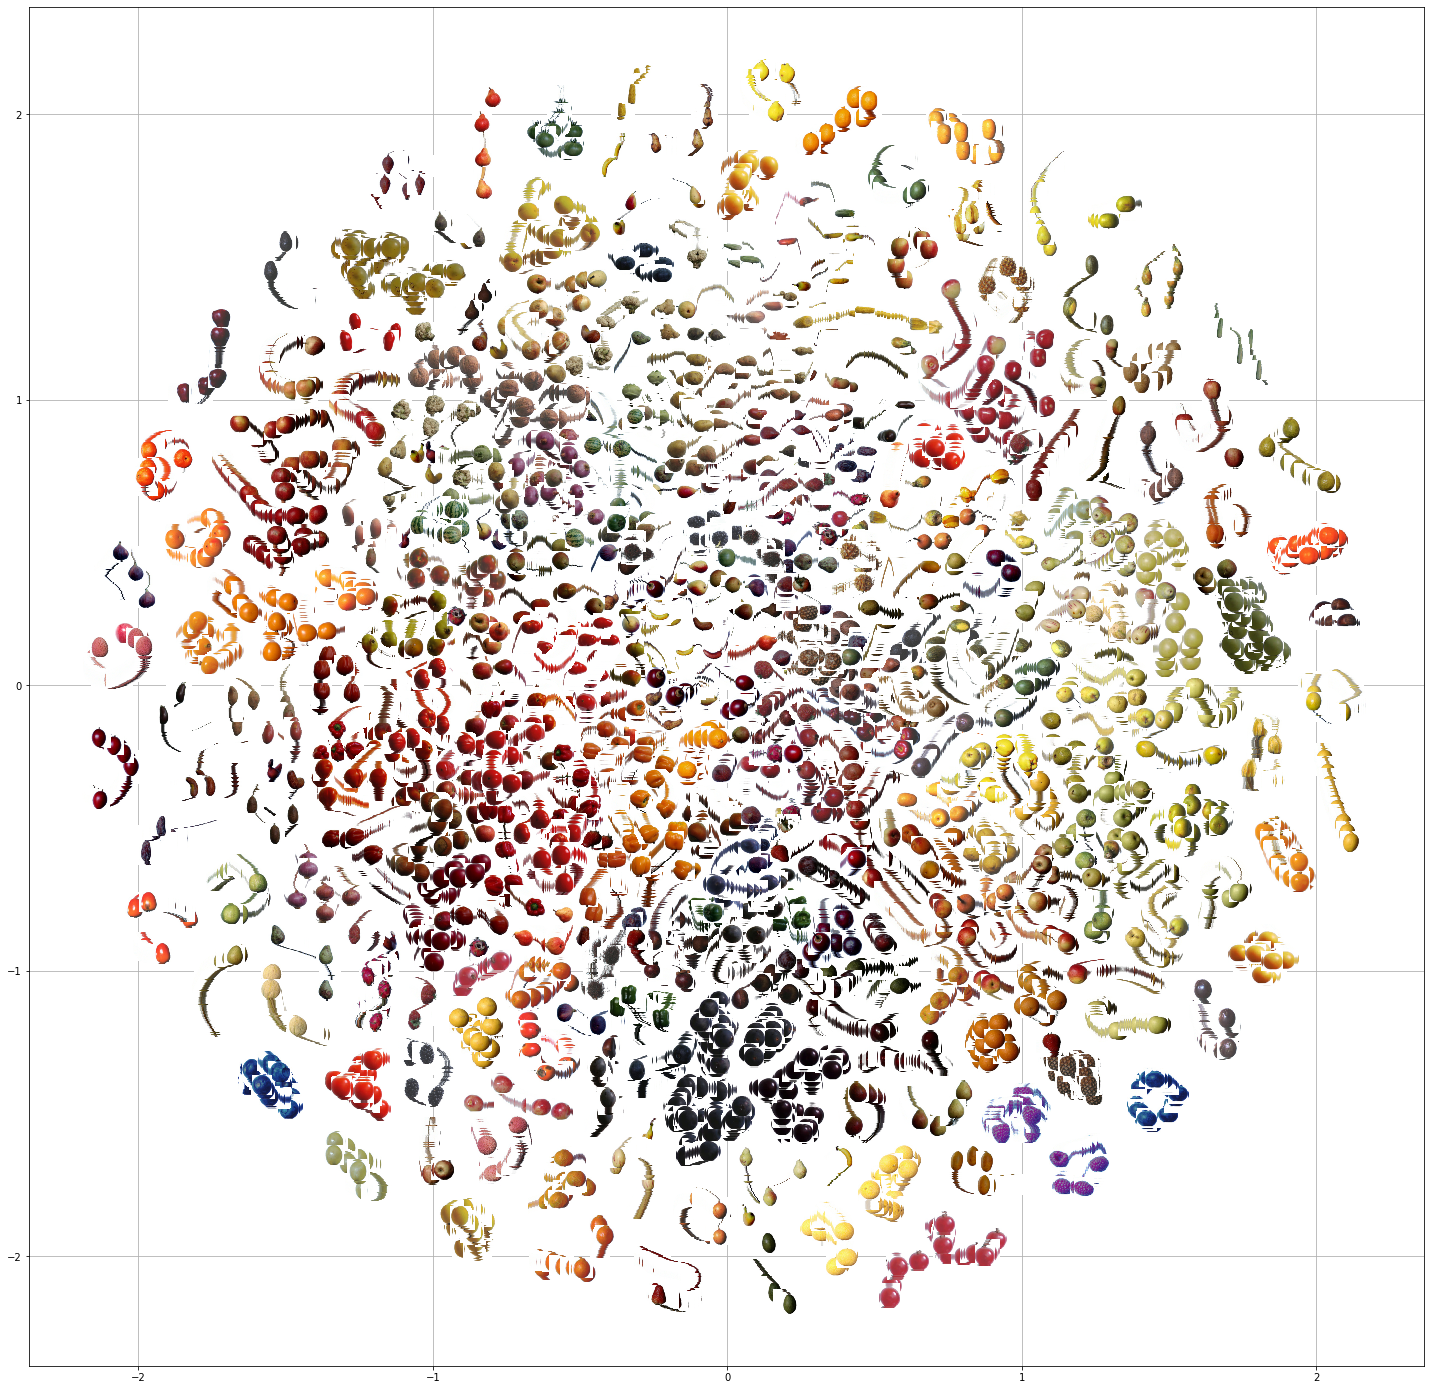

In [20]:
visualize_scatter_with_images(tsne_result_scaled, fruit_images, image_zoom=0.4, figsize=(25, 25))

# Spilt data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [67692, 131]

In [22]:
print("X_train.shape",X_train.shape)
print("y_train.shape",y_train.shape)

X_train.shape (50769, 50)
y_train.shape (50769,)


# Train Random Forest Classifier

In [23]:
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)

In [24]:
test_predictions = forest.predict(X_test)

In [25]:
print(test_predictions[:10])

[ 43 130  94 118   6 115  50  14  58 128]


In [24]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

Accuracy with RandomForest: 99.580453


# Train SVM

In [25]:
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train, y_train) 

In [26]:
test_predictions = svm_clf.predict(X_test)

In [27]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM: {0:.6f}".format(precision))

Accuracy with SVM: 99.887727


# Validate the models on the Validation Data

## parepare validation dataset

In [28]:
validation_fruit_images = []
validation_labels = [] 
for fruit_dir_path in glob.glob("./fruits-360/Test/*"):
    fruit_label = fruit_dir_path.replace('\\','/').split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (image_width, image_height))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [29]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])

In [30]:
validation_images_scaled = scaler.transform([i.flatten() for i in validation_fruit_images])

In [31]:
validation_pca_result = pca.transform(validation_images_scaled)

## Validate with Random Forest

In [32]:
test_predictions = forest.predict(validation_pca_result)

In [33]:
precision = accuracy_score(test_predictions, validation_label_ids) * 100
print("Validation Accuracy with Random Forest: {0:.6f}".format(precision))

Validation Accuracy with Random Forest: 82.550247


## Validate with SVM

In [34]:
test_predictions = svm_clf.predict(validation_pca_result)

In [35]:
precision = accuracy_score(test_predictions, validation_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 94.265691


# Save Models

In [80]:

# scaler

# pca
joblib.dump(pca,save_path+"pca.joblib",compress=True)
# random forest
joblib.dump(forest,save_path+"rf_clf.joblib",compress=True)
# svm
joblib.dump(svm_clf,save_path+"svm_clf.joblib",compress=True)

['./PCA_SVM_RF/svm_clf.joblib']

In [82]:
%ls .\PCA_SVM_RF

Volume in drive C is System
 Volume Serial Number is DA0C-534A

 Directory of C:\Users\Yuxiang\source\INFO6105\project\PCA_SVM_RF

27/11/2020  01:42 am    <DIR>          .
27/11/2020  01:42 am    <DIR>          ..
27/11/2020  01:41 am         2,938,442 pca.joblib
27/11/2020  01:41 am         2,270,327 rf_clf.joblib
27/11/2020  01:41 am           165,063 scaler.joblib
27/11/2020  01:41 am        15,602,292 svm_clf.joblib
               4 File(s)     20,976,124 bytes
               2 Dir(s)  149,572,546,560 bytes free
